In [1]:
using Oceananigans
using NCDatasets
using Printf
using CairoMakie
using Oceananigans.Fields
using Oceananigans.AbstractOperations: volume
using NaNStatistics

In [2]:
using TopographicHorizontalConvection: HorizontalConvectionSimulation

In [3]:
#function to find  χ same method used for turbulent and diffusive
function find_χ(ds)
    x = ds["xC"][4+1:end-4]; Nx = length(x);
    z = ds["zC"][4+1:end-4]; Nz = length(z);
    time = ds["time"][:];
    Δx = reshape(diff(ds["xF"])[4+1:end-4], Nx,1,1);
    Δz = reshape(diff(ds["zF"])[4+1:end-4], 1,1,Nz);
    ΔA = Δx; #flat in y -- 2 dimensional
    ΔV = ΔA.*Δz;
    χ = zeros(size(time,1));
    for n in 1:size(time, 1)
        χt = ds["chi"][4+1:end-4, 1, 4+1:end-4, n]
        wet = χt.!=0.
        χt[.!wet] .= NaN
        χ[n] = nansum(
            χt .*
            ΔV,
            dims=(1,2,3)
        )[1,1,1]
    end
    return χ
    
    
end

find_χ (generic function with 1 method)

In [19]:
#input for turbulent χ's
prefix = "/Users/hfdrake/code/HorizontalConvection/output/turbulent_h0.6_Ra";
suffix = "_buoyancy.nc";

ds_array = [NCDataset(string(prefix, "100000.0", suffix)),
            NCDataset(string(prefix, "1.0e6", suffix)),
            NCDataset(string(prefix, "1.0e7", suffix))];
            #NCDataset(string(prefix, "1.0e8", suffix))];




χ_array = [find_χ(ds) for ds in ds_array];



In [20]:
#turbulent chi arrays below

χ_turb_1e5 = χ_array[1];
χ_turb_1e6 = χ_array[2];
χ_turb_1e7 = χ_array[3];
#χ_turb_1e8 = χ_array[4];

317-element Vector{Float64}:
   1.295268874031689
   0.4087690933336454
   0.4675629289767685
   0.38923178908629863
   0.5112419157356785
   0.4502043353260497
   0.3669863527801703
   0.4186772940585184
   0.35033887157121135
   0.3471644278045556
   ⋮
 201.7530745969309
 204.8809302589909
 204.27834500480313
 204.77471574236455
 208.20428118114023
 208.45467604911767
 213.3743022952707
 214.0605027706806
 218.63988141510998

In [21]:
#now the corresponding diffusive χ's
prefix_diff = "/Users/hfdrake/code/HorizontalConvection/output/diffusive_h0.6_Ra";
suffix_diff = "_buoyancy.nc";

ds_array_diff = [NCDataset(string(prefix_diff, "100000.0", suffix_diff)),
            NCDataset(string(prefix_diff, "1.0e6", suffix_diff)),
            NCDataset(string(prefix_diff, "1.0e7", suffix_diff))]
            #NCDataset(string(prefix_diff, "1.0e8", suffix_diff))];

χ_array_diff = [find_χ(ds) for ds in ds_array_diff];

In [22]:
χ_diff_1e5 = χ_array_diff[1];
χ_diff_1e6 = χ_array_diff[2];
χ_diff_1e7 = χ_array_diff[3];
#χ_diff_1e8 = χ_array_diff[4];

317-element Vector{Float64}:
 1.2952690295390377
 0.28461183283522284
 0.20245140304194703
 0.16573122177130736
 0.14377626239514724
 0.12876436848891035
 0.11766022550810999
 0.10900917690777984
 0.10201686800842359
 0.09620858302034696
 ⋮
 0.005236647038990982
 0.005229861133251907
 0.005223188473055339
 0.005216627161643917
 0.005210175334145377
 0.005203831157035034
 0.005197592827605928
 0.005191458573449258
 0.00518542665194315

In [25]:
Nusselt_1e5 = χ_turb_1e5 ./ χ_diff_1e5;
Nusselt_1e6 = χ_turb_1e6 ./ χ_diff_1e6;
Nusselt_1e7 = χ_turb_1e7 ./ χ_diff_1e7;
#Nusselt_1e8 = χ_turb_1e8 ./ χ_diff_1e8;


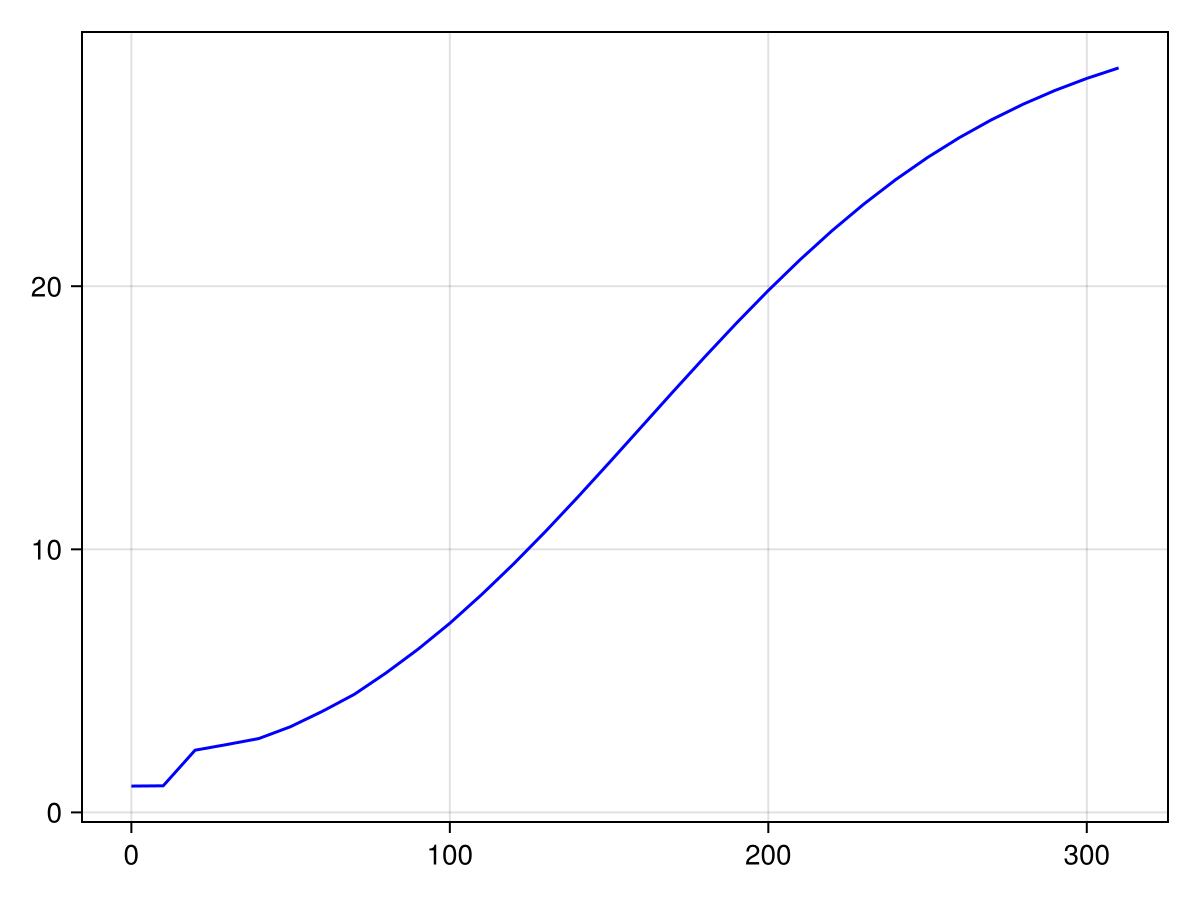

In [26]:
lines(ds_array[1]["time"][:], Nusselt_1e5, label="Ra = 1e5", color=:blue)

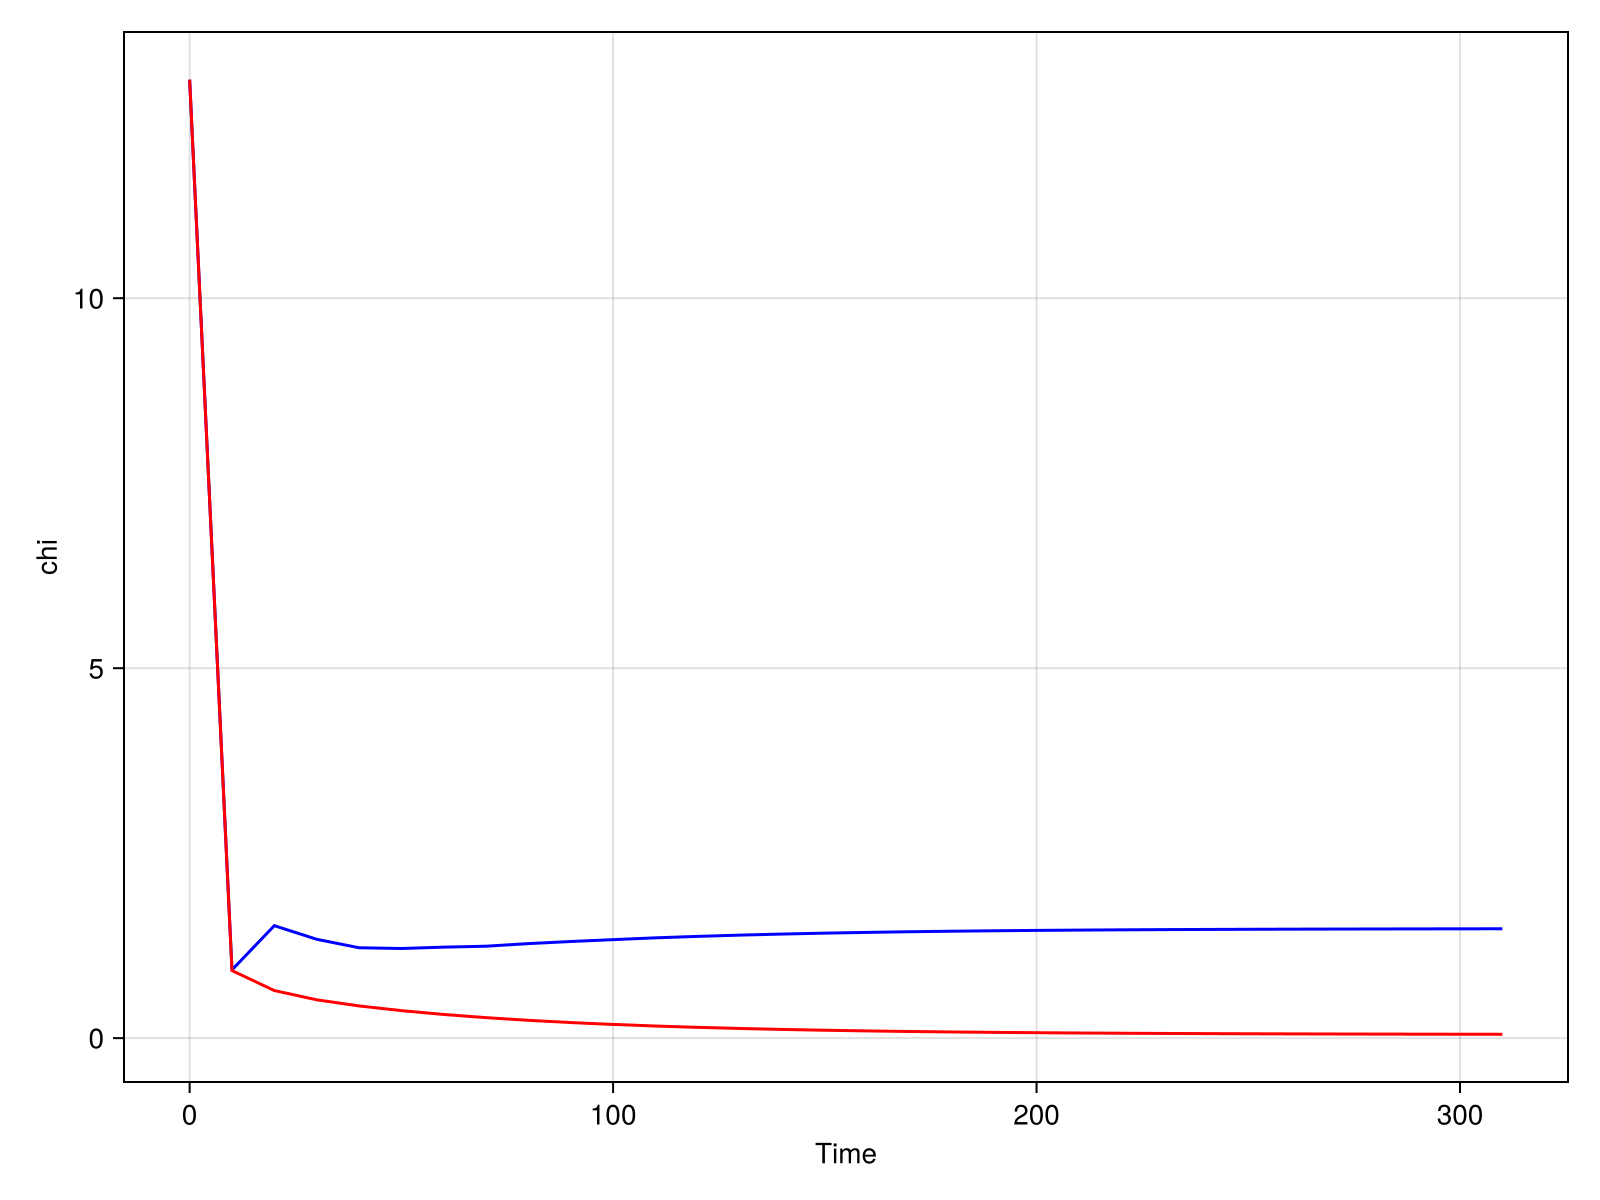

In [28]:
#turbulent versus diffusive chi for Ra=1e5
fig = Figure(size = (800, 600))
ax = Axis(fig[1, 1], xlabel = "Time", ylabel = "chi")
lines!(ax, ds_array[1]["time"][:], χ_turb_1e5, label="Ra = 1e5", color=:blue)
lines!(ax, ds_array[1]["time"][:], χ_diff_1e5, label="Ra = 1e5", color=:red)
fig

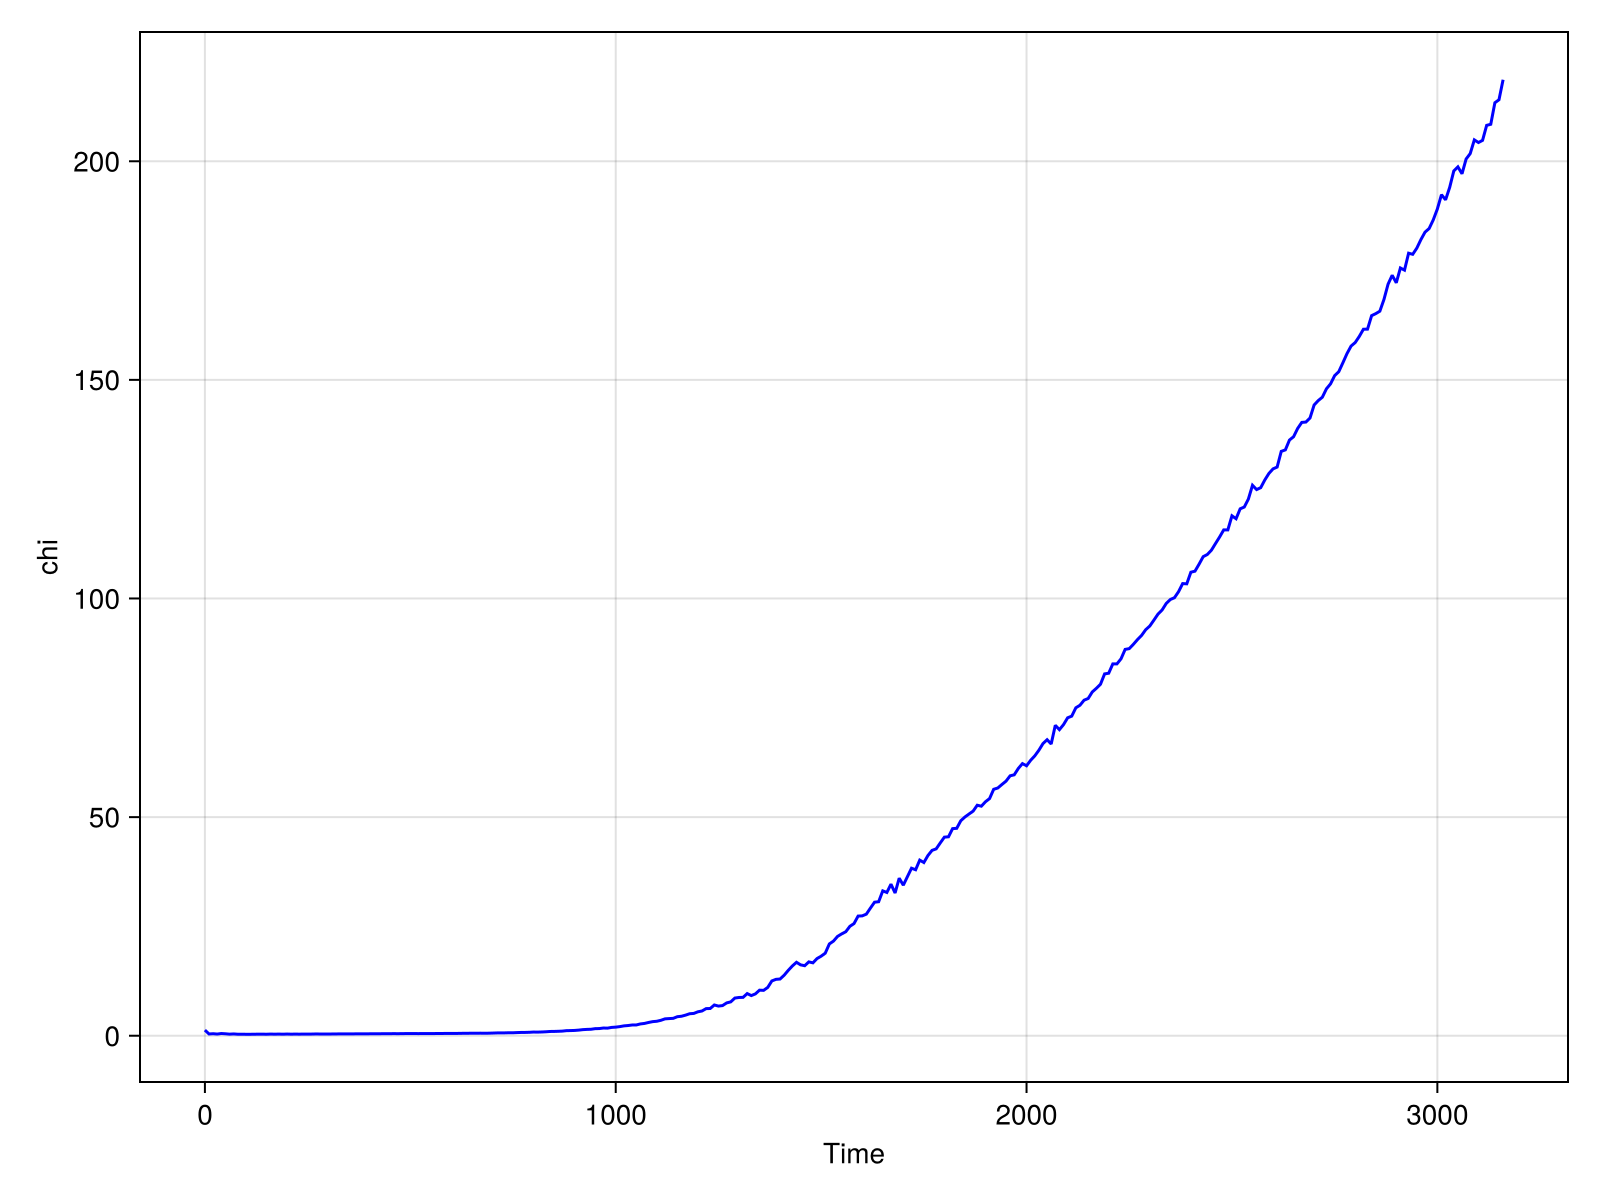

In [36]:
#turbulent versus diffusive chi for Ra=1e7
fig = Figure(size = (800, 600))
ax = Axis(fig[1, 1], xlabel = "Time", ylabel = "chi")
lines!(ax, ds_array[3]["time"][:], χ_turb_1e7, label="Ra = 1e7", color=:blue)
lines!(ax, ds_array[3]["time"][:], χ_diff_1e7, label="Ra = 1e7", color=:red)
fig

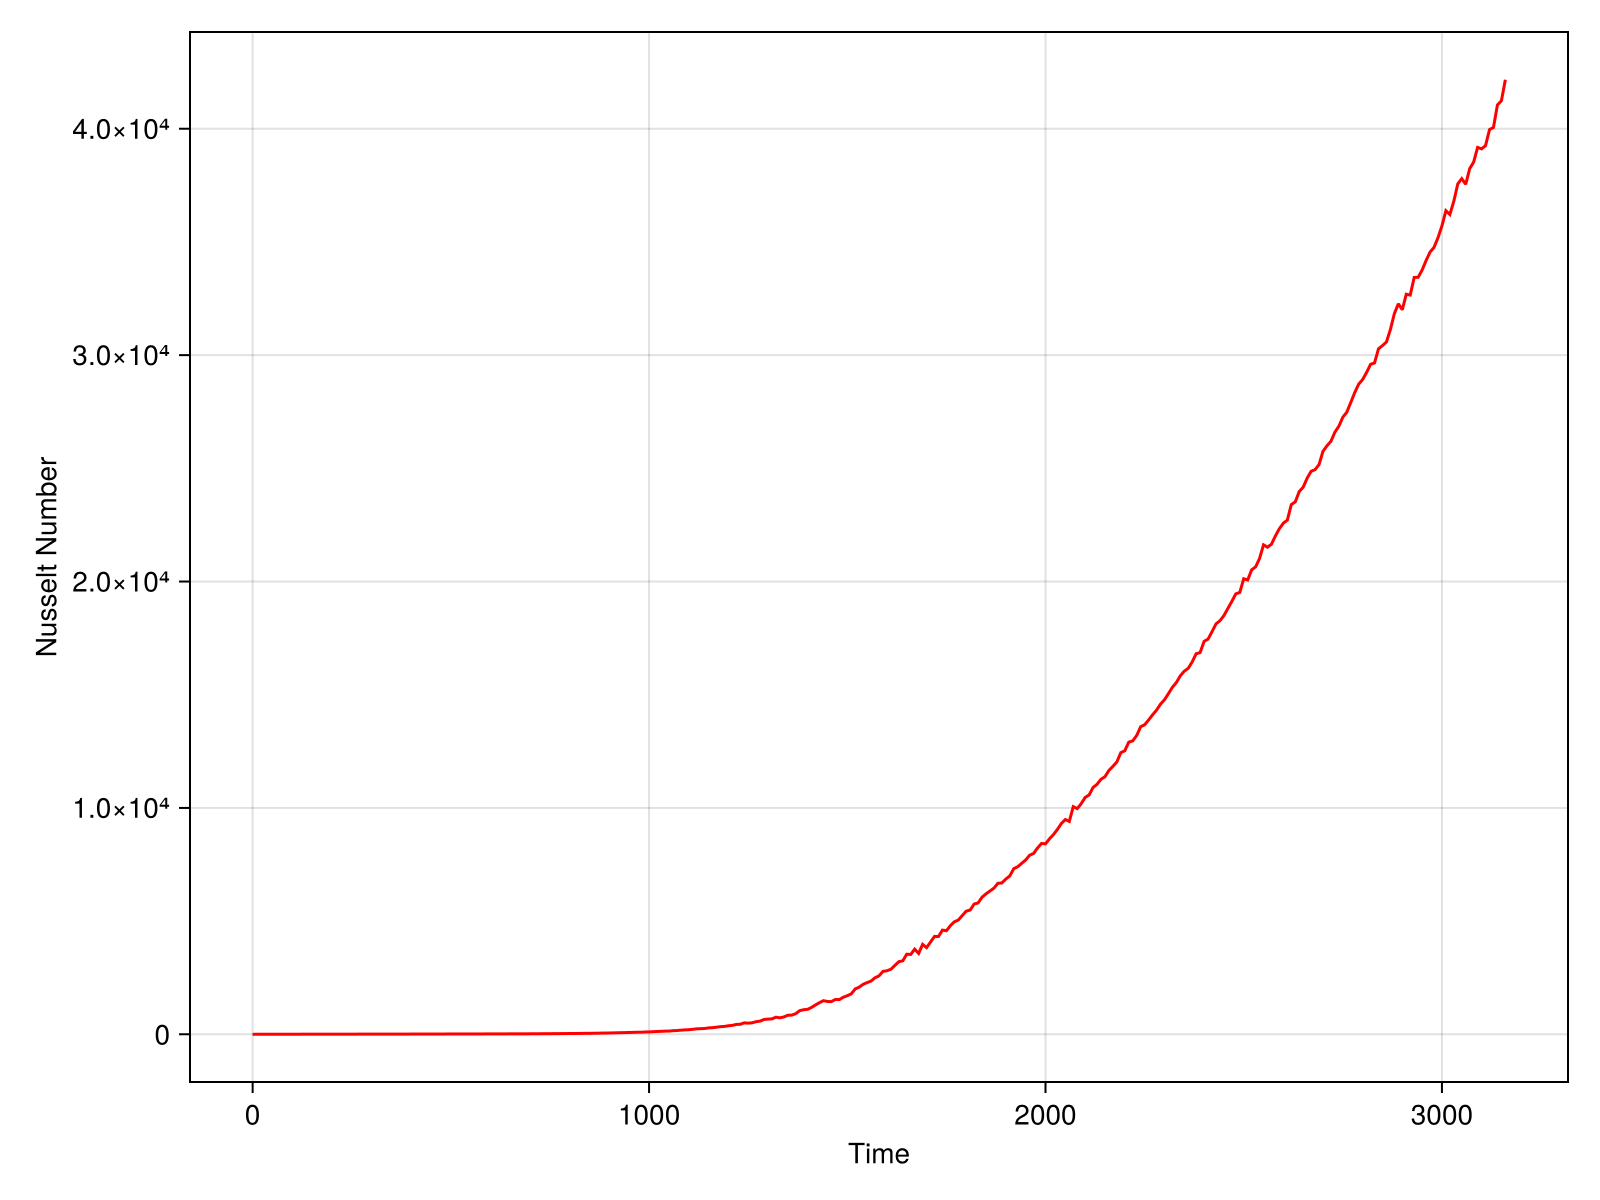

In [29]:
fig = Figure(size = (800, 600))
ax = Axis(fig[1, 1], xlabel = "Time", ylabel = "Nusselt Number")
#lines!(ds_array[1]["time"][:], Nusselt_1e5, label="Ra = 1e5", color=:blue)
#lines!(ds_array[2]["time"][:], Nusselt_1e6, label="Ra = 1e6", color=:green)
lines!(ds_array[3]["time"][:], Nusselt_1e7, label="Ra = 1e7", color=:red)
#lines!(ds_array[4]["time"][:], Nusselt_1e8, label="Ra = 1e8", color=:purple)

fig

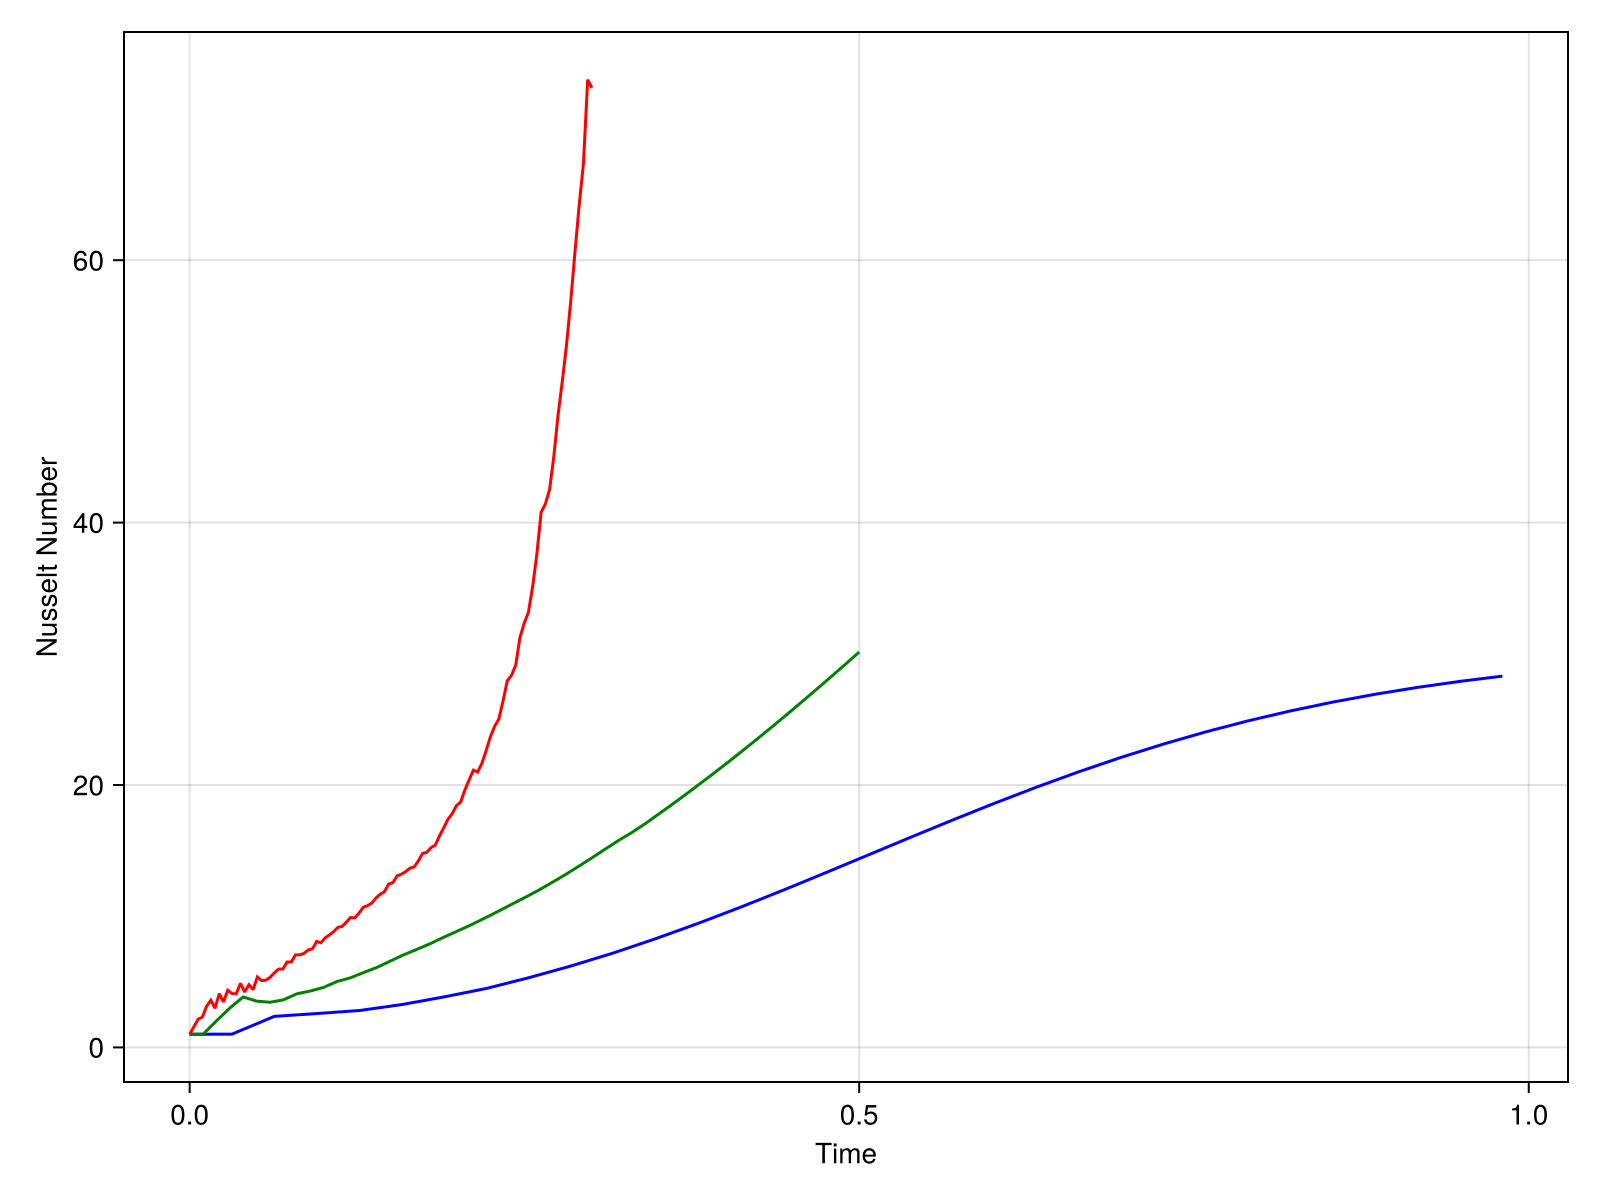

In [127]:
#normalize time arrays by multiplying by 1/sqrt(Ra) to compare the time scales of the simulations

time_1e5 = ds_array[1]["time"][:].*1/sqrt(1e5);
time_1e6 = ds_array[2]["time"][:].*1/sqrt(1e6);
time_1e7 = ds_array[3]["time"][:].*1/sqrt(1e7);
time_1e8 = ds_array[4]["time"][:].*1/sqrt(1e8);

times = [time_1e5, time_1e6, time_1e7, time_1e8];

#plotting the normalized time arrays
fig = Figure(resolution = (800, 600))
ax = Axis(fig[1, 1], xlabel = "Time", ylabel = "Nusselt Number")
lines!(time_1e5, Nusselt_1e5, label="Ra = 1e5", color=:blue)
lines!(time_1e6, Nusselt_1e6, label="Ra = 1e6", color=:green)
lines!(time_1e7, Nusselt_1e7, label="Ra = 1e7", color=:red)
#lines!(time_1e8, Nusselt_1e8, label="Ra = 1e8", color=:purple)
fig


In [85]:
#bottom buoyancy plots

#average of b(z=-h) over x from rocha improved bounds paper fig 2

b_bottom_1e5 = ds_array[1]["b"][4+1:end-4,1,4+1,:] #Ra = 1e5
b_bottom_1e6 = ds_array[2]["b"][4+1:end-4,1,4+1,:] #Ra = 1e6

using NaNStatistics
function buoyancy_bottom_avg(b_bottom)
    bottom_avg = zeros(size(b_bottom[1,:]));
    for n in 1:size(b_bottom,2)
        bb = b_bottom[:,n]
        wet = bb.!=0.
        bb[.!wet] .= NaN

        bottom_avg[n] = nanmean(bb, dims=1)[1,1]
    end
    return bottom_avg
end



#b_bottom_average = nanmean(b_bottom, dims=1)


buoyancy_bottom_avg (generic function with 1 method)

In [97]:
b_bottom_1e5 = ds_array[1]["b"][4+1:end-4,1,4+1,:]; #Ra = 1e5
b_bottom_avg_1e5 = buoyancy_bottom_avg(b_bottom_1e5);

b_bottom_1e6 = ds_array[2]["b"][4+1:end-4,1,4+1,:]; #Ra = 1e6
b_bottom_avg_1e6 = buoyancy_bottom_avg(b_bottom_1e6);

b_bottom_1e7 = ds_array[3]["b"][4+1:end-4,1,4+1,:]; #Ra = 1e7
b_bottom_avg_1e7 = buoyancy_bottom_avg(b_bottom_1e7);

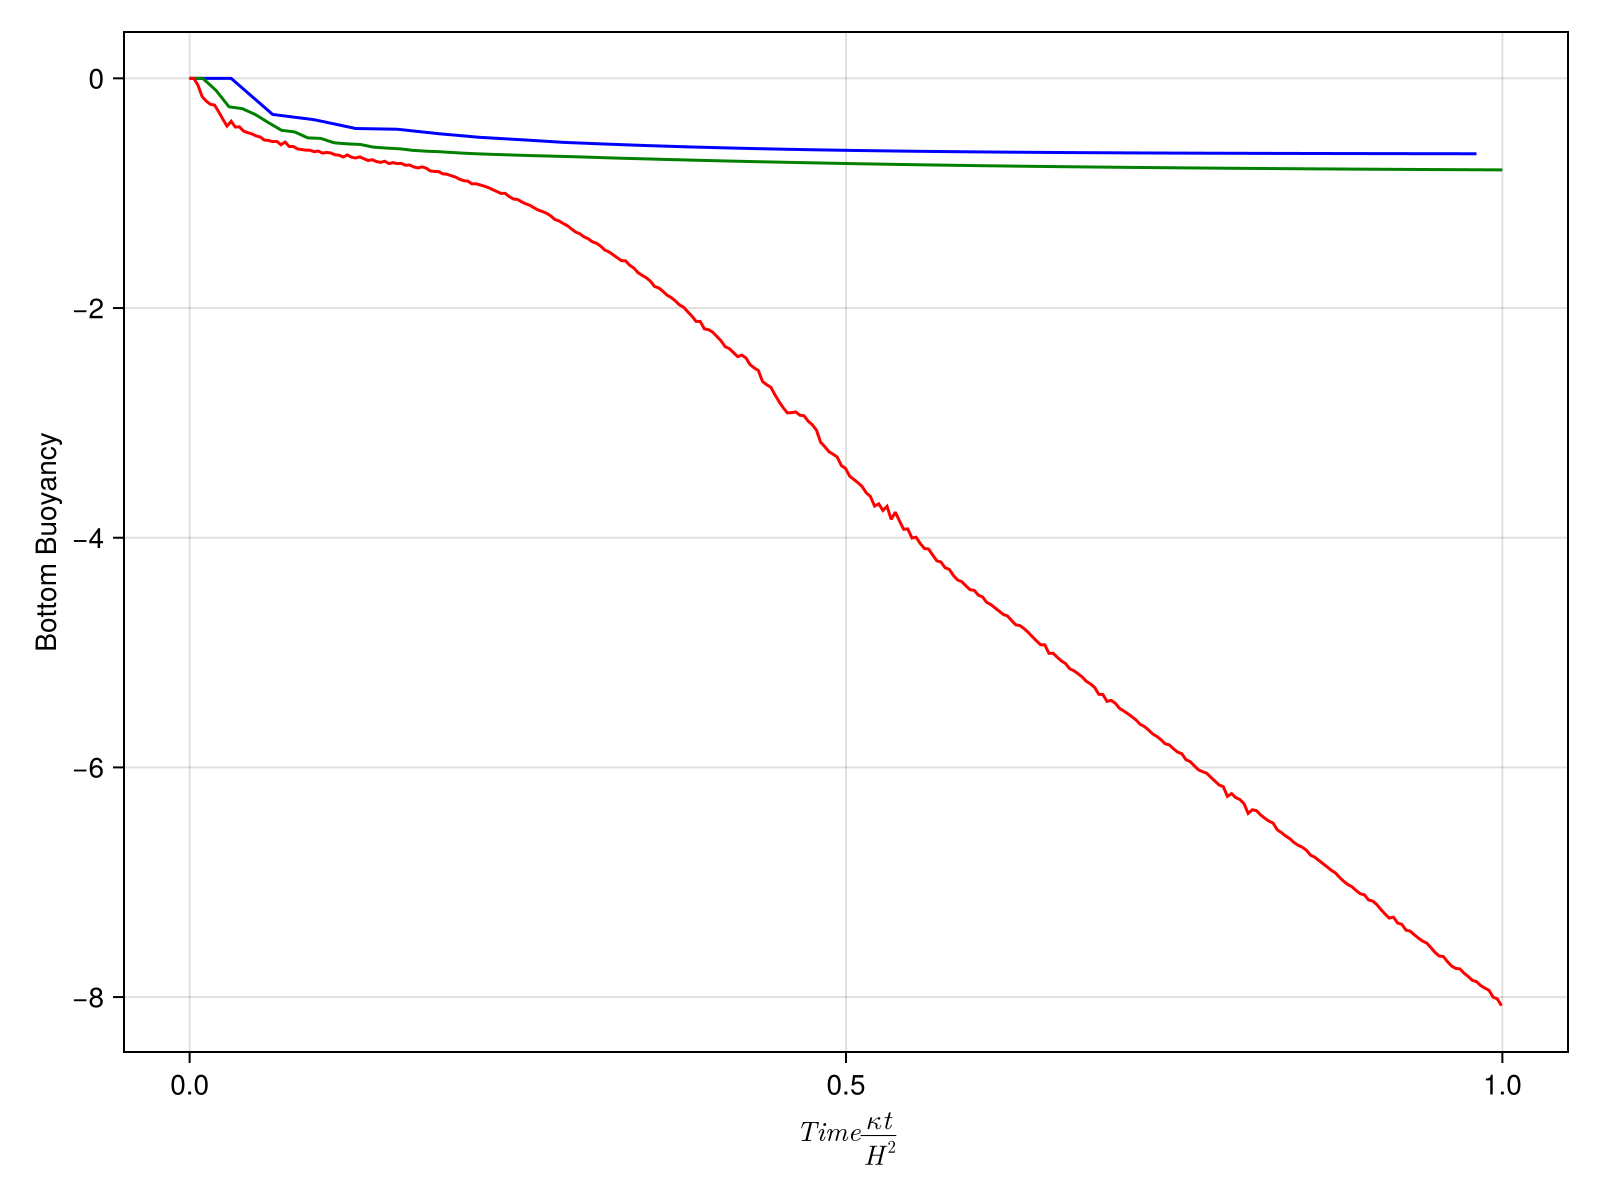

In [100]:
Pr = 1.0
b★ = 1.0
H = 1.0
#ν = sqrt(Pr * b★ * H^3 / Ra)
#κ = ν * Pr

ν_1e5 = sqrt(Pr * b★ * H^3 / 1e5)
ν_1e6 = sqrt(Pr * b★ * H^3 / 1e6)
ν_1e7 = sqrt(Pr * b★ * H^3 / 1e7)

κ_1e5 = ν_1e5 * Pr
κ_1e6 = ν_1e6 * Pr
κ_1e7 = ν_1e7 * Pr


normalized_time_1e5 = ds_array[1]["time"][:] .* (κ_1e5 / H^2)
normalized_time_1e6 = ds_array[2]["time"][:] .* (κ_1e6 / H^2)
normalized_time_1e7 = ds_array[3]["time"][:] .* (κ_1e7 / H^2)

fig = Figure(size = (800, 600))
ax = Axis(fig[1, 1], xlabel = L"Time \frac{κt}{H^2}", ylabel = "Bottom Buoyancy")
lines!(ax, normalized_time_1e5, b_bottom_avg_1e5, label="Ra = 1e5", color=:blue)
lines!(ax, normalized_time_1e6, b_bottom_avg_1e6, label="Ra = 1e6", color=:green)
lines!(ax, normalized_time_1e7, b_bottom_avg_1e7, label="Ra = 1e7", color=:red)
fig

